## Select Model for Analysis

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.random import normal

from preprocess.acf import *
from preprocess.gaussianize import *

from scipy.stats import wasserstein_distance

In [32]:
alpha_D = 0.5
alpha_G = 0.5
batch_size = 1000
n_batches = 1000

data_name = "SP500_daily"
data_path = "data/"+data_name+".csv"

base_path = "redo_capstone/"
final_model = f"trained_generator_final_epoch_SP500_daily_Alpha_D_{alpha_D}_Alpha_G_{alpha_G}_BatchSize_{batch_size}_N_Batches_{n_batches}"
path = base_path + final_model

print(f"Loading: {final_model}")
generator = load_model(path, compile=False)

def dateparse(d):
    return pd.Timestamp(d)

data = pd.read_csv(data_path, parse_dates={'datetime': ['Date']}, date_parser=dateparse)
df = data['Close']


Loading: trained_generator_final_epoch_SP500_daily_Alpha_D_0.5_Alpha_G_0.5_BatchSize_1000_N_Batches_1000


c:\Users\henry\OneDrive - Queen's University\Desktop\Year 4\Classes\MTHE493\QuantGan\QuantGAN\.venv\lib\site-packages\keras\src\layers\core\lambda_layer.py:327: UserWarning: model.tf_tcn is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(
C:\Users\henry\AppData\Local\Temp\ipykernel_6380\1399573155.py:19: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv(data_path, parse_dates={'datetime': ['Date']}, date_parser=dateparse)


## Preprocess

In [18]:
returns = df.shift(1)/df - 1
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()
log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))
scalers = {'standardScaler1': standardScaler1, 
           'gaussianize': gaussianize, 
           'standardScaler2': standardScaler2}
receptive_field_size = 127  # p. 17
log_returns_rolled = rolling_window(log_returns_preprocessed, receptive_field_size)

In [26]:
noise = normal([512, 1, len(log_returns_preprocessed) + 127-1, 3])
y = generator(noise).numpy().squeeze()

y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()

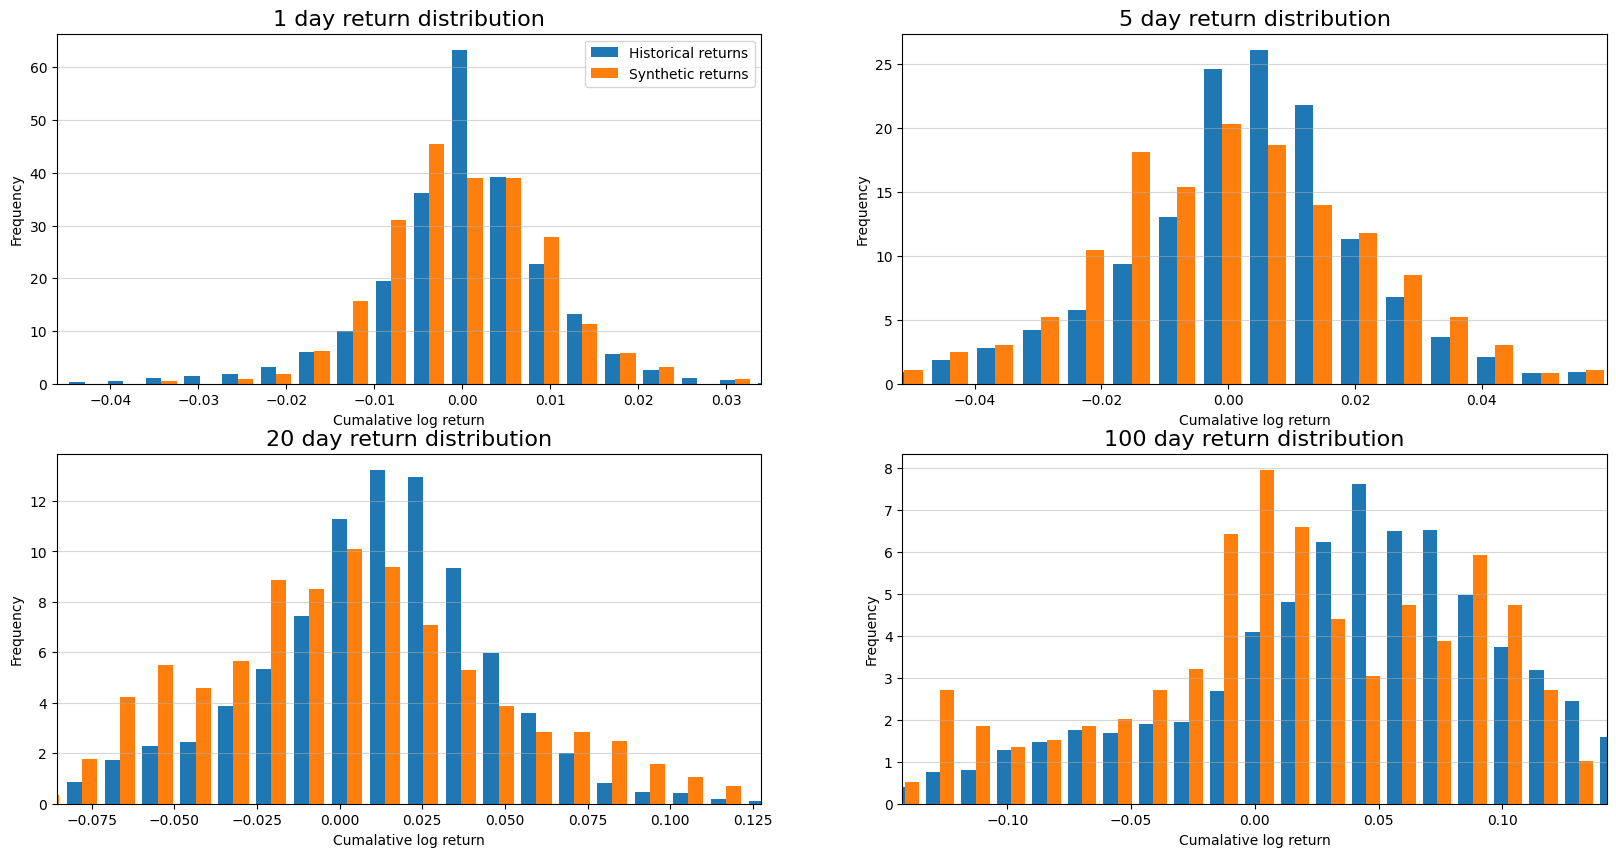

In [28]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T[1][:], windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])


In [40]:
n_bins = 50
windows = [1, 5, 20, 100]

for i in range(len(windows)):
    post_wass_avg = 0
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    
    print(f"Wasserstien Distance of {windows[i]} Day Return Distribution")
    
    for j in range(len(y)):
        fake_dist = rolling_window(y.T[j][:], windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
        post_wass_avg += wasserstein_distance(fake_dist, real_dist)
        
    post_wass_avg /= len(y)
    
    print(post_wass_avg, "\n")
    

Wasserstien Distance of 1 Day Return Distribution
0.001501201267023116 

Wasserstien Distance of 5 Day Return Distribution
0.0040583444444240715 

Wasserstien Distance of 20 Day Return Distribution
0.01228797280403294 

Wasserstien Distance of 100 Day Return Distribution
0.04436895877183091 

